In [1]:
import pickle
import warnings
from copy import deepcopy
from pprint import pprint

import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import seaborn as sns
import shap
from catboost import CatBoostClassifier
from sklearn.compose import ColumnTransformer
from sklearn.ensemble import RandomForestClassifier
from sklearn.inspection import permutation_importance
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import (accuracy_score, classification_report,
                             confusion_matrix, f1_score, make_scorer,
                             precision_score, recall_score, roc_auc_score,
                             roc_curve)
from sklearn.model_selection import (RandomizedSearchCV, StratifiedKFold,
                                     train_test_split)
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import OneHotEncoder, StandardScaler


# from tqdm import tqdm
sns.set()
shap.initjs()
warnings.filterwarnings('ignore')

In [2]:
RANDOM_STATE = 42
RANDOM_SEED = RANDOM_STATE

In [3]:
pd.set_option('display.max_columns', None)
pd.set_option('display.float_format', '{:.3f}'.format)

In [56]:
df = pd.read_csv('../data/clean/train.csv')

In [57]:
df.head()

,checking_status,duration_months,credit_history,purpose,credit_amount,savings_status,employment_years,installment_commitment,personal_status,other_parties,residence_years,property_magnitude,age_years,other_payment_plans,housing,existing_credits,job,num_dependents,own_telephone,foreign_worker,target
0,no checking,18,critical/other existing credit,radio/tv,1800,<100,1<=X<4,4,male single,none,2,car,24,none,own,2,skilled,1,none,yes,0
1,<0,24,existing paid,radio/tv,2439,<100,<1,4,female div/dep/mar,none,4,real estate,35,none,own,1,skilled,1,yes,yes,1
2,no checking,36,no credits/all paid,repairs,2613,<100,1<=X<4,4,male single,none,2,car,27,none,own,2,skilled,1,none,yes,0
3,no checking,15,existing paid,education,4623,100<=X<500,1<=X<4,3,male single,none,2,life insurance,40,none,own,1,high qualif/self emp/mgmt,1,yes,yes,1
4,<0,21,existing paid,furniture/equipment,3599,<100,4<=X<7,1,female div/dep/mar,none,4,car,26,none,rent,1,unskilled resident,1,none,yes,0


Мы будем решать задачу бинарной классификации, где класс 1 соответствует "плохой" заявке, которую мы хотим отклонить.  
Класс 0 - "хорошей" заявке, хотим одобрить.

In [58]:
# Сгенерируем дополнительные фичи
df['check_status_dur_std'] = df.groupby('checking_status')['duration_months'].transform('std')
df['check_status_dur_median'] = df.groupby('checking_status')['duration_months'].transform('median')
df['check_status_dur_mean'] = df.groupby('checking_status')['duration_months'].transform('mean')
df['check_status_credit_am_std'] = df.groupby('checking_status')['credit_amount'].transform('std')
df['check_status_credit_am_meadian'] = df.groupby('checking_status')['credit_amount'].transform('median')
df['check_status_credit_am_mean'] = df.groupby('checking_status')['credit_amount'].transform('mean')

df['credit_history_dur_std'] = df.groupby('credit_history')['duration_months'].transform('std')
df['credit_history_dur_median'] = df.groupby('credit_history')['duration_months'].transform('median')
df['credit_history_dur_mean'] = df.groupby('credit_history')['duration_months'].transform('mean')
df['credit_history_credit_am_std'] = df.groupby('credit_history')['credit_amount'].transform('std')
df['credit_history_credit_am_median'] = df.groupby('credit_history')['credit_amount'].transform('median')
df['credit_history_credit_am_mean'] = df.groupby('credit_history')['credit_amount'].transform('mean')

df['amount_to_duration'] = df['credit_amount'] / df['duration_months']
df['installment_mul_duration'] = df['installment_commitment'] * df['duration_months']

In [59]:
X = df.drop('target', axis=1).columns
y = ['target']

In [60]:
cols2drop = []
target = ['target']
num_features = [c for c in df.columns if c not in target and pd.api.types.is_numeric_dtype(df[c])]
cat_features = [c for c in df.columns if c not in target and c not in num_features]
assert len(target) + len(num_features) + len(cat_features) + len(cols2drop) == len(df.columns)

Учитывая малый размер выборки, мы разобьём её на две части  
- *train* - для обучения моделей с использованием кросс-валидации  
- *test* - для тестирования лучшей модели

In [61]:
train, test = train_test_split(df, test_size=0.25, random_state=RANDOM_STATE, stratify=df[y])
print(f'Размер обучающей выборки {train.shape}, это составляет {len(train)/len(df):.0%} данных')
print(f'Размер тестовой выборки {test.shape}, это составляет {len(test)/len(df):.0%} данных')

Размер обучающей выборки (600, 35), это составляет 75% данных
Размер тестовой выборки (200, 35), это составляет 25% данных


In [10]:
kfold = StratifiedKFold(n_splits=5, random_state=RANDOM_STATE, shuffle=True)

### Declaring functions

Создадим кастомный скоринг weighted_accuracy.

Описание данных сообщает нам валюту счёта - `Deutsche Mark`.  
Учитывая низкий уровень инфляции (как следствие - низкий уровень процентных ставок по кредитным продуктам), одобрение "плохой" заявки может нести существенные финансовые потери.  
В этой связи мы будем сильнее штрафовать модель за FN (то есть одобрение "плохой" заявки) будем использовать вес -10.  
Вес верного предсказания отрицательного класса (TN) будет 2, мы хотим одобрять "хорошие" заявки и зарабатывать на этом.  
Вес неверного предсказания положительного класса (FP) будет -1, мы не хотим терять потенциал и отклонять "хорошие" заявки.  
Вес верно отклонённой заявки (TP) будет равен 0.  

Таким образом мы будем стараться максимизировать показатель `weighted_accuracy`.

In [11]:
def weighted_accuracy(y_true, y_pred):
    """Custom scoring"""

    cost_matrix = np.array([
        [2, -1],  # для предсказания класса 0 (одобренная заявка)
        [-10, 0]   # для предсказания класса 1 (отклоненная заявка)
    ])

    costs = cost_matrix[y_true, y_pred]

    return np.sum(costs) / len(y_true)

In [12]:
weighted_accuracy_scorer = make_scorer(weighted_accuracy, greater_is_better=True)

In [13]:
def rs(model, grid_params, n_iter, x_train, y_train, verbose=0, random_state=RANDOM_STATE):
    """Hyperparameters tuning with GridSearchCV returns roc_auc CV score"""

    print("Performing grid search...")
    print("Hyperparameters to be evaluated:")
    pprint(grid_params)
    print()

    clf_rnd_gs = RandomizedSearchCV(
        model,
        grid_params,
        random_state=random_state,
        n_iter=n_iter,
        cv=5,
        verbose=verbose,
        n_jobs=-2,
        scoring=weighted_accuracy_scorer,
    )

    clf_rnd_gs.fit(x_train, y_train.values.ravel())

    print("Best parameters:")
    for elem in sorted(clf_rnd_gs.best_params_):
        print(f"{elem}: {clf_rnd_gs.best_params_.get(elem)}")

    return (clf_rnd_gs.best_estimator_, clf_rnd_gs)

In [14]:
def calc_metrics(actual_classes, predicted_classes, predicted_proba):
    """Calculate ROC-AUC, accuracy, precision, recall, f1, weighted_accuracy"""

    rocauc = roc_auc_score(actual_classes, predicted_proba[:,1])
    accuracy = accuracy_score(actual_classes, predicted_classes)
    precision = precision_score(actual_classes, predicted_classes)
    recall = recall_score(actual_classes, predicted_classes)
    f1 = f1_score(actual_classes, predicted_classes)
    weighted_acc = weighted_accuracy(actual_classes, predicted_classes)

    return (rocauc, accuracy, precision, recall, f1, weighted_acc)


In [15]:
def plot_cm_rocauc(actual_classes, predicted_classes, predicted_proba, sorted_labels=["Good", "Bad"]):
    """Ploting ROC curve and confusion matrix using predictions based on CV"""

    matrix = confusion_matrix(actual_classes, predicted_classes)
    plt.figure(figsize=(10, 6))
    sns.heatmap(
        matrix,
        annot=True,
        xticklabels=sorted_labels,
        yticklabels=sorted_labels,
        cmap="gnuplot",
        fmt="g",
    )
    plt.xlabel("Predicted")
    plt.ylabel("Actual")
    plt.title("Confusion Matrix")
    plt.show()

    probabilities_one = predicted_proba[:, 1]

    sns.set(rc={"figure.figsize": (9, 6)})

    fpr, tpr, thresholds = roc_curve(actual_classes, probabilities_one)
    plt.figure()

    plt.plot(fpr, tpr)

    plt.plot([0, 1], [0, 1], linestyle="--")

    plt.xlim([-0.05, 1.0])
    plt.ylim([0.0, 1.05])

    plt.xlabel("False Positive Rate")
    plt.ylabel("True Positive Rate")

    plt.title("ROC")

    plt.show()

    print(classification_report(actual_classes, predicted_classes))


In [16]:

def cross_val_predict(model, kfold, X, y):
    """Predicting classes using CV(KFold)"""

    model_ = deepcopy(model)

    no_classes = len(np.unique(y))

    actual_classes = np.empty([0], dtype=int)
    predicted_classes = np.empty([0], dtype=int)
    predicted_proba = np.empty([0, no_classes])

    for train_ndx, test_ndx in kfold.split(X, y):
        train_X, train_y, test_X, test_y = (
            X.iloc[train_ndx],
            y.iloc[train_ndx],
            X.iloc[test_ndx],
            y.iloc[test_ndx],
        )

        actual_classes = np.append(actual_classes, test_y)

        model_.fit(train_X, train_y)
        predicted_classes = np.append(predicted_classes, model_.predict(test_X))

        try:
            predicted_proba = np.append(
                predicted_proba, model_.predict_proba(test_X), axis=0
            )
        except Exception:
            predicted_proba = np.append(
                predicted_proba,
                np.zeros((len(test_X), no_classes), dtype=float),
                axis=0,
            )

    plot_cm_rocauc(actual_classes, predicted_classes, predicted_proba)

    metrics = calc_metrics(actual_classes, predicted_classes, predicted_proba)

    print("Train data StratifiedKFold CV:")
    print(f"ROC-AUC {metrics[0]:.3f}\nWeighted_accuracy {metrics[-1]:.3f}")

    return metrics

In [17]:
def save_results(name):
    '''Accumulating training results'''

    global metrics

    results.loc[name] = [*metrics]

    return

In [18]:
results = pd.DataFrame({'ROC-AUC': [],
                        'Accuracy': [],
                        'Precision': [],
                        'Recall': [],
                        'F1_score' : [],
                        'Weighted_accuracy': []})

## Logistic Regression

Учитывая малый размер выборки, начнём с простой модели.

In [19]:
num_pipeline = Pipeline(steps=[
    ('scale', StandardScaler())
])

cat_pipeline = Pipeline(steps=[
    ('one-hot', OneHotEncoder(handle_unknown='ignore', drop='first', sparse_output=False))
])

pre_processor = ColumnTransformer(transformers=[
    ('number', num_pipeline, num_features),
    ('category', cat_pipeline, cat_features)
])

lr_pipeline = Pipeline(steps=[
    ('preprocess', pre_processor),
    ('classify', LogisticRegression(random_state=RANDOM_STATE))
])

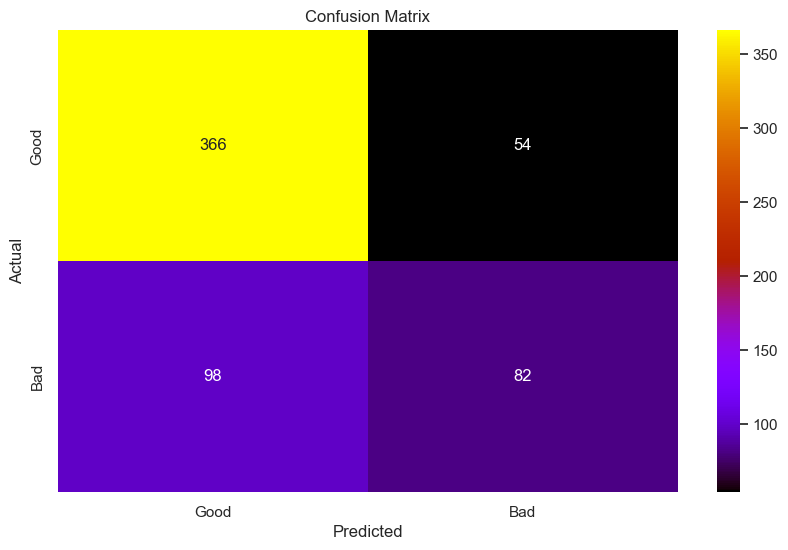

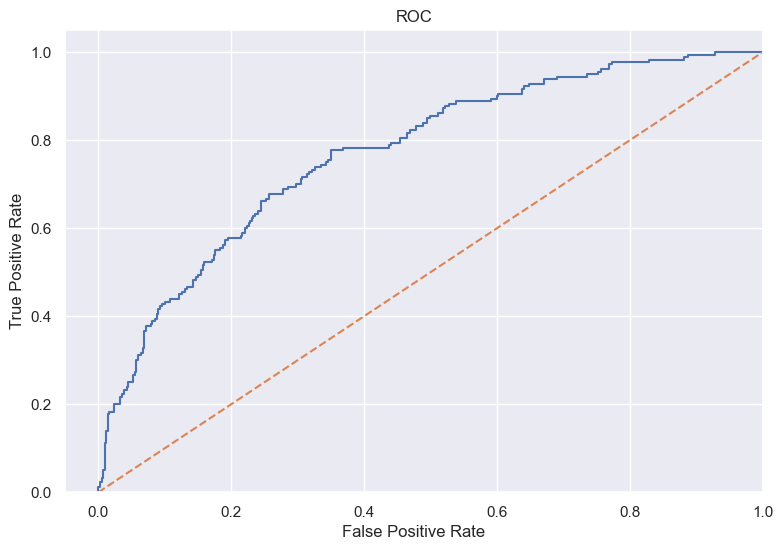

              precision    recall  f1-score   support

           0       0.79      0.87      0.83       420
           1       0.60      0.46      0.52       180

    accuracy                           0.75       600
   macro avg       0.70      0.66      0.67       600
weighted avg       0.73      0.75      0.74       600

Train data StratifiedKFold CV:
ROC-AUC 0.771
Weighted_accuracy -0.503


In [20]:
# Baseline
metrics = cross_val_predict(lr_pipeline, kfold, train[X], train[y]);

In [21]:
save_results('Baseline_LogReg')

In [22]:
grid_params_lr = {
    'classify__C': np.logspace(-4, 4, 10),
    'classify__class_weight': ['balanced', None],
    'classify__max_iter': range(500, 5001, 500),
    'classify__penalty': ['l2', 'l1', 'elasticnet']
}

n_iter = 500

best_lr_model, lr_rs = rs(lr_pipeline, grid_params_lr, n_iter, train[X], train[y])

Performing grid search...
Hyperparameters to be evaluated:
{'classify__C': array([1.00000000e-04, 7.74263683e-04, 5.99484250e-03, 4.64158883e-02,
       3.59381366e-01, 2.78255940e+00, 2.15443469e+01, 1.66810054e+02,
       1.29154967e+03, 1.00000000e+04]),
 'classify__class_weight': ['balanced', None],
 'classify__max_iter': range(500, 5001, 500),
 'classify__penalty': ['l2', 'l1', 'elasticnet']}

Best parameters:
classify__C: 0.046415888336127774
classify__class_weight: balanced
classify__max_iter: 2500
classify__penalty: l2


In [23]:
with open('../models/Logistic_regression.pkl', 'wb') as file:
    pickle.dump(best_lr_model, file)

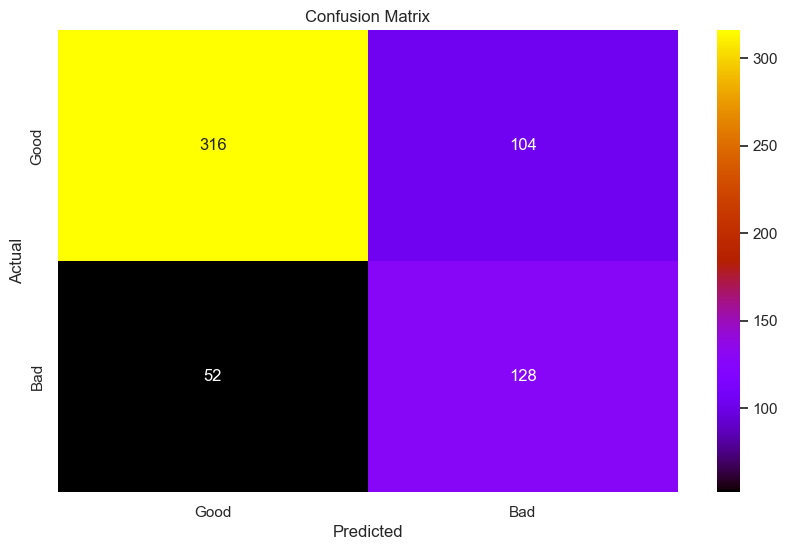

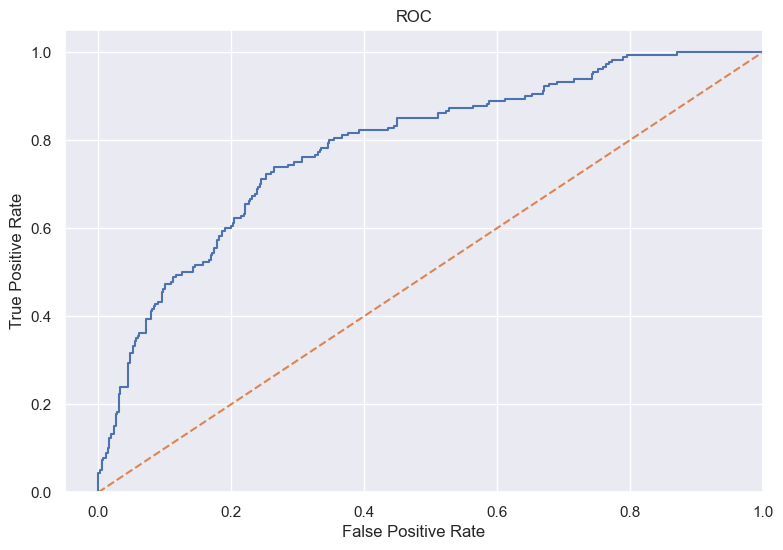

              precision    recall  f1-score   support

           0       0.86      0.75      0.80       420
           1       0.55      0.71      0.62       180

    accuracy                           0.74       600
   macro avg       0.71      0.73      0.71       600
weighted avg       0.77      0.74      0.75       600

Train data StratifiedKFold CV:
ROC-AUC 0.786
Weighted_accuracy 0.013


In [24]:
metrics = cross_val_predict(best_lr_model, kfold, train[X], train[y]);

In [25]:
save_results('Logistic_regression')
results

,ROC-AUC,Accuracy,Precision,Recall,F1_score,Weighted_accuracy
Baseline_LogReg,0.771,0.747,0.603,0.456,0.519,-0.503
Logistic_regression,0.786,0.740,0.552,0.711,0.621,0.013


## Random Forest

In [26]:
pre_processor_rf = ColumnTransformer(transformers=[
    ('category', cat_pipeline, cat_features)
])

rf_pipeline = Pipeline(steps=[
    ('preprocess', pre_processor_rf),
    ('classify', RandomForestClassifier(random_state=RANDOM_STATE, class_weight='balanced'))
])

grid_params_rf = {
    'classify__n_estimators': range(50, 1000, 100),
    'classify__max_depth': range(1, 13, 1),
    'classify__min_samples_leaf': [10, 25, 50, 75, 100],
    'classify__criterion': ['entropy', 'gini'],
    'classify__max_features': [None, 0.75, 0.5, 0.25, 'sqrt', 'log2']
}

n_iter = 500

best_rf_model, rf_rs = rs(rf_pipeline, grid_params_rf, n_iter, train[X], train[y])

Performing grid search...
Hyperparameters to be evaluated:
{'classify__criterion': ['entropy', 'gini'],
 'classify__max_depth': range(1, 13),
 'classify__max_features': [None, 0.75, 0.5, 0.25, 'sqrt', 'log2'],
 'classify__min_samples_leaf': [10, 25, 50, 75, 100],
 'classify__n_estimators': range(50, 1000, 100)}

Best parameters:
classify__criterion: entropy
classify__max_depth: 3
classify__max_features: sqrt
classify__min_samples_leaf: 50
classify__n_estimators: 850


In [27]:
with open('../models/Random_forest.pkl', 'wb') as file:
    pickle.dump(best_rf_model, file)

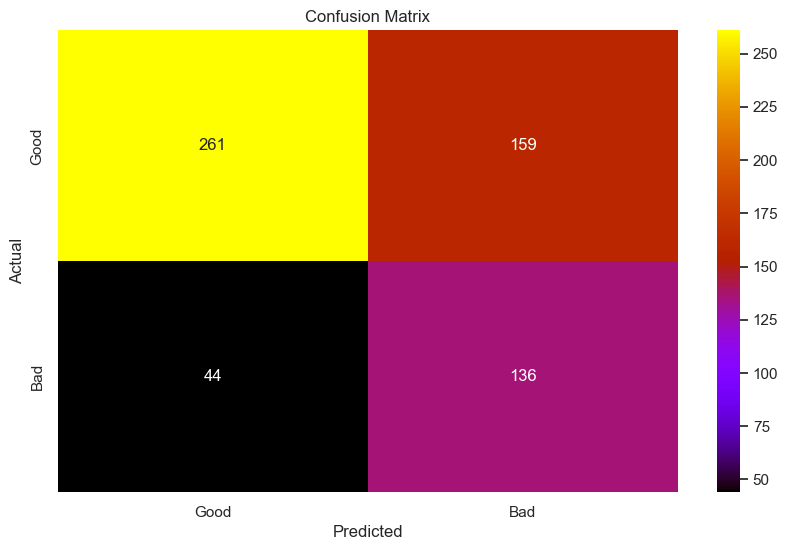

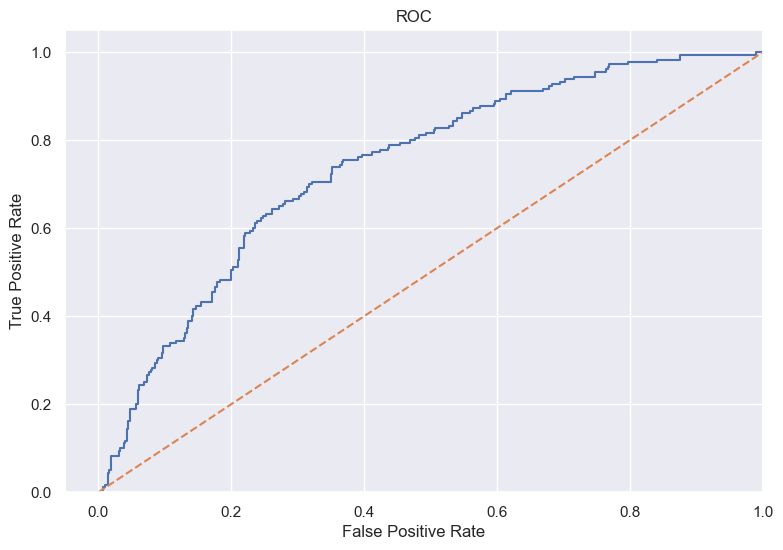

              precision    recall  f1-score   support

           0       0.86      0.62      0.72       420
           1       0.46      0.76      0.57       180

    accuracy                           0.66       600
   macro avg       0.66      0.69      0.65       600
weighted avg       0.74      0.66      0.68       600

Train data StratifiedKFold CV:
ROC-AUC 0.740
Weighted_accuracy -0.128


In [28]:
metrics = cross_val_predict(best_rf_model, kfold, train[X], train[y]);

In [29]:
save_results('Random_forest')
results

,ROC-AUC,Accuracy,Precision,Recall,F1_score,Weighted_accuracy
Baseline_LogReg,0.771,0.747,0.603,0.456,0.519,-0.503
Logistic_regression,0.786,0.740,0.552,0.711,0.621,0.013
Random_forest,0.740,0.662,0.461,0.756,0.573,-0.128


## CatBoost


In [30]:
params = {
    'cat_features': cat_features,
    'loss_function': 'Logloss',
    'random_seed': RANDOM_SEED,
    'verbose': 0
}

In [31]:
grid_params_cb = {
    'n_estimators': range(200, 1001, 200),
    'learning_rate': [0.001, 0.01, 0.025, 0.05, 0.1, 0.2, 0.3],
    'depth': [1, 2, 3, 4, 8, 12],
    'l2_leaf_reg': np.linspace(2, 30, 10, dtype=int),
    'colsample_bylevel': [x / 100 for x in range(10, 51, 10)] + [None],
    'subsample': [x / 100 for x in range(50, 100, 15)] + [None],
    'bootstrap_type': ['Bayesian', 'Bernoulli', 'MVS'],-
    'auto_class_weights': ['Balanced', None]
}

n_iter = 500

best_cb_model, cb_rs = rs(CatBoostClassifier(**params), grid_params_cb, n_iter, train[X], train[y])

Performing grid search...
Hyperparameters to be evaluated:
{'auto_class_weights': ['Balanced', None],
 'bootstrap_type': ['Bayesian', 'Bernoulli', 'MVS'],
 'colsample_bylevel': [0.1, 0.2, 0.3, 0.4, 0.5, None],
 'depth': [1, 2, 3, 4, 8, 12],
 'l2_leaf_reg': array([ 2,  5,  8, 11, 14, 17, 20, 23, 26, 30]),
 'learning_rate': [0.001, 0.01, 0.025, 0.05, 0.1, 0.2, 0.3],
 'n_estimators': range(200, 1001, 200),
 'subsample': [0.5, 0.65, 0.8, 0.95, None]}

Best parameters:
auto_class_weights: Balanced
bootstrap_type: MVS
colsample_bylevel: 0.1
depth: 8
l2_leaf_reg: 26
learning_rate: 0.001
n_estimators: 800
subsample: 0.5


In [32]:
with open('../models/Catboost.pkl', 'wb') as file:
    pickle.dump(best_cb_model, file)

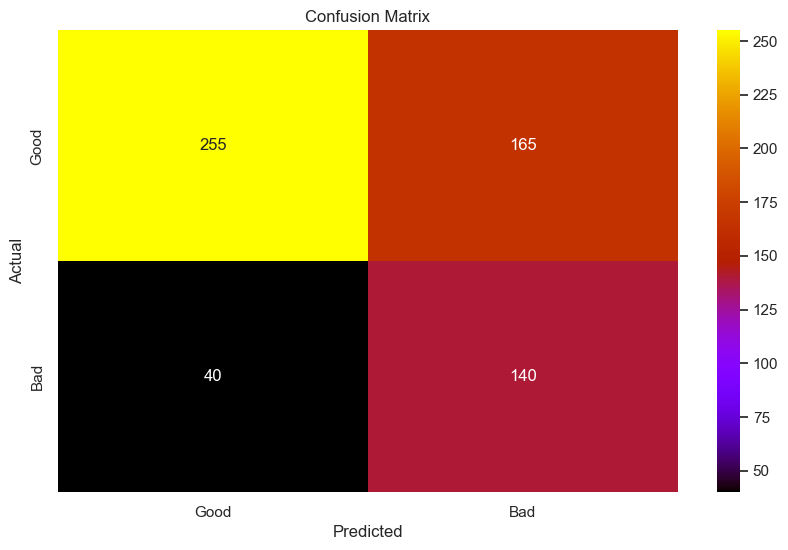

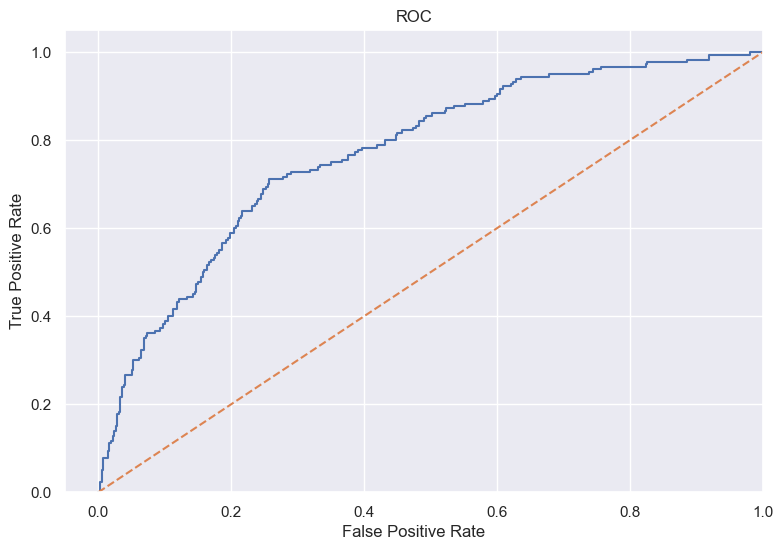

              precision    recall  f1-score   support

           0       0.86      0.61      0.71       420
           1       0.46      0.78      0.58       180

    accuracy                           0.66       600
   macro avg       0.66      0.69      0.65       600
weighted avg       0.74      0.66      0.67       600

Train data StratifiedKFold CV:
ROC-AUC 0.771
Weighted_accuracy -0.092


In [33]:
metrics = cross_val_predict(best_cb_model, kfold, train[X], train[y])

In [34]:
save_results('Catboost')
results

,ROC-AUC,Accuracy,Precision,Recall,F1_score,Weighted_accuracy
Baseline_LogReg,0.771,0.747,0.603,0.456,0.519,-0.503
Logistic_regression,0.786,0.740,0.552,0.711,0.621,0.013
Random_forest,0.740,0.662,0.461,0.756,0.573,-0.128
Catboost,0.771,0.658,0.459,0.778,0.577,-0.092


Модель логистической регрессии показывает лучший результат `wieghted_accuracy` в совокупности с максимальным `f1_score`.  
Проверим модель Logistic_regression на тестовой выборке

In [97]:
with open('../models/Logistic_Regression.pkl', 'rb') as file:
    best_model = pickle.load(file)

best_model.fit(train[X], train[y])
pred = best_model.predict(test[X])
pred_proba = best_model.predict_proba(test[X])[:,1]

metrics = calc_metrics(test[y].values.ravel(), pred, pred_proba)
roc_auc = roc_auc_score(test[y], pred_proba)
f1 = f1_score(test[y], pred)
accuracy = accuracy_score(test[y], pred)
precision = precision_score(test[y], pred)
recall = recall_score(test[y], pred)
w_a = weighted_accuracy(test[y].values.ravel(), pred)
print(f'{"lr"} | {roc_auc = :.3f} | {f1 = :.3f} | {precision = :.3f} | {recall = :.3f} | {accuracy = :.3f} | {w_a = }')

matrix = confusion_matrix(test[y], pred)
plt.figure(figsize=(10, 6))
sns.heatmap(
    matrix,
    annot=True,
    xticklabels=['Good', 'Bad'],
    yticklabels=['Good', 'Bad'],
    cmap="gnuplot",
    fmt="g",
)
plt.xlabel("Predicted")
plt.ylabel("Actual")
plt.title("Confusion Matrix")
plt.show()

IndexError: too many indices for array: array is 1-dimensional, but 2 were indexed

lr | roc_auc = 0.757 | f1 = 0.518 | precision = 0.733 | recall = 0.607 | accuracy = 0.715 | weighted_acc = -0.015


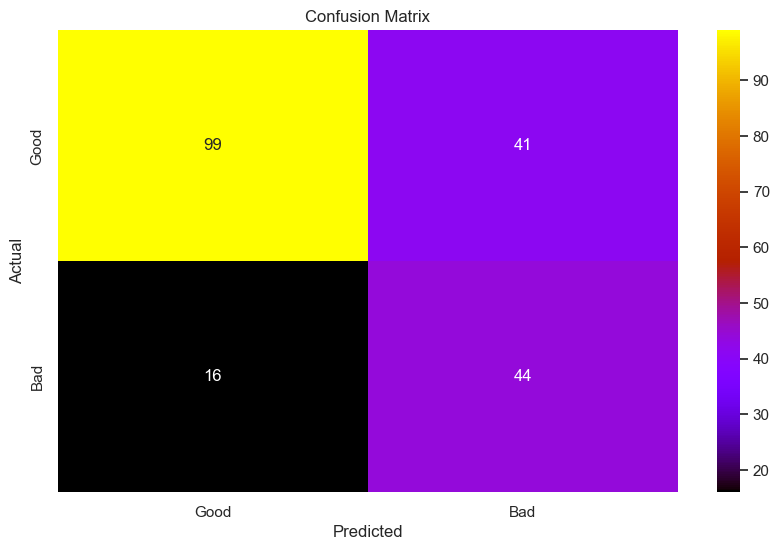

In [103]:
with open('../models/Logistic_Regression.pkl', 'rb') as file:
    best_model = pickle.load(file)

best_model.fit(train[X], train[y])
pred = best_model.predict(test[X])
pred_proba = best_model.predict_proba(test[X])

roc_auc, accuracy, f1, precision, recall, weighted_acc = calc_metrics(test[y].values.ravel(), pred, pred_proba)

print(f'{"lr"} | {roc_auc = :.3f} | {f1 = :.3f} | {precision = :.3f} | {recall = :.3f} | {accuracy = :.3f} | {weighted_acc = :.3f}')

matrix = confusion_matrix(test[y], pred)
plt.figure(figsize=(10, 6))
sns.heatmap(
    matrix,
    annot=True,
    xticklabels=['Good', 'Bad'],
    yticklabels=['Good', 'Bad'],
    cmap="gnuplot",
    fmt="g",
)
plt.xlabel("Predicted")
plt.ylabel("Actual")
plt.title("Confusion Matrix")
plt.show()

## Feature Importance

In [96]:
result = permutation_importance(
    best_model,
    test[X],
    test[y],
    scoring=weighted_accuracy_scorer,
    random_state=RANDOM_STATE,
    n_repeats=50
)
importance_df = pd.DataFrame({'feature': test[X].columns, 'importance': result.importances_mean})
importance_df = importance_df.sort_values('importance', ascending=False)
display(importance_df[:15])


,feature,importance
0,checking_status,3.996
12,age_years,3.618
3,purpose,3.528
22,check_status_dur_mean,3.402
5,savings_status,3.078
24,check_status_credit_am_meadian,2.448
8,personal_status,2.358
18,own_telephone,2.304
13,other_payment_plans,2.250
16,job,1.620


Наиболее важными являются признаки, описывающие состояние текущего и накопительного счетов, возраст, цель кредита.  

Для повышения качества рекомендуется обогатить датасет следующими данными:  

1. Кредитная история:  
    Суммарный показатель кредитоспособности, основанный на истории предыдущих кредитов, платежей, задолженностей.  
    Прямо отражает, насколько ответственно заявитель относится к финансовым обязательствам.  

2. Соотношение долга к доходу (Debt-to-Income Ratio, DTI):  
    Процент ежемесячного дохода, который идет на погашение долгов (кредиты, ипотека, алименты и др.).  
    Показывает финансовую нагрузку на заявителя и его способность погашать новый кредит.  
    Наш датасет обладает аналогичным признаком по запрашиваемому займу,  
    может быть полезным показатель DTI по всем имеющимся обязательствам.

3.  Стаж работы и доход:  
    Текущее место работы, должность, уровень  дохода.  
    Стабильный доход и работа - ключевые факторы, влияющие на способность погашать кредит.